## Python code for chapter 2 (McElreath, 2016)

In [1]:
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd
import seaborn as sns

#### 2.2: Building a model: binomial likelihood with (flat) beta prior


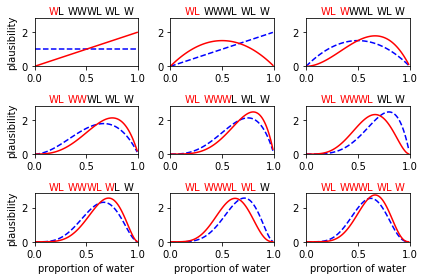

<Figure size 432x288 with 0 Axes>

In [2]:
data22 = ['W', 'L', 'W', 'W', 'W', 'L', 'W', 'L', 'W']
aPost = np.cumsum([1 if x == 'W' else 0 for x in data22]) + 1
aPost.shape
a = np.insert(aPost, 0, 1)
bPost = np.cumsum([0 if x == 'W' else 1 for x in data22]) + 1
b = np.insert(bPost, 0, 1)

beta.stats(a[0], b[0], moments='mvsk')    # mean, var, skew, kurtosis (mvsk)

# update: {[p ^ x] * [(1 - p) ^ (n - x)]} * {[ p ^ (a - 1)] * [(1-p) ^ (b - 1)]} / B(a,b)
pRange = np.arange(0, 1, 0.01)

yVals = beta.pdf(pRange, a[0], b[0])
for i in range(1, len(a)):
    yVals = np.append(yVals, beta.pdf(pRange, a[i], b[i]))
yMax = max(yVals)

plt.figure(1)
for i in range(0, len(a) - 1):
    plotloc = '33' + str(i + 1)
    plt.subplot(plotloc)
    plt.plot(pRange, beta.pdf(pRange, a[i], b[i]), 'b--',
             pRange, beta.pdf(pRange, a[i + 1], b[i + 1]), 'r-')
    plt.axis([0, 1, 0, yMax + .1])
    plt.tight_layout()
    if i in [6, 7, 8]:
        plt.xlabel('proportion of water')
    if i in [0, 3, 6]:
        plt.ylabel('plausibility')
    for j in range(0, len(a) - 1):
        tmpCol = 'black'
        if i >= j:
            tmpCol = 'red'
        tmpX = .05 + (j + 1) * .09
        plt.text(tmpX, yMax + .3, data22[j], color=tmpCol)
plt.show()
plt.savefig('fig22a.pdf')

#### Section 2.4.3: Grid approximation

Text(0.5, 1.0, 'normalish prior')

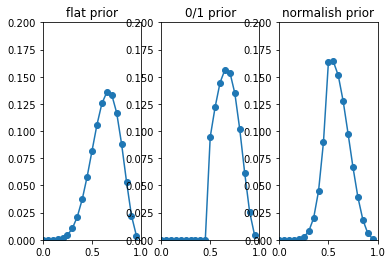

In [3]:
p_grid = np.arange(0, 1, .05)
prior = np.repeat(1, 20)
likelihood = binom.pmf(k=6, n=9, p=p_grid)
unstd_posterior = likelihood * prior
posterior = unstd_posterior / sum(unstd_posterior)
plt.plot(p_grid, posterior, 'bo-')

prior2 = [0 if x < 0.5 else 1 for x in p_grid]
unstd_posterior2 = likelihood * prior2
posterior2 = unstd_posterior2 / sum(unstd_posterior2)

prior3 = np.exp(-5*abs(p_grid - 0.5))
unstd_posterior3 = likelihood * prior3
posterior3 = unstd_posterior3 / sum(unstd_posterior3)

plt.figure(1)
plt.subplot(131)
plt.plot(p_grid, posterior, 'o-')
plt.title('flat prior')
plt.axis([0, 1, 0, .2])
plt.subplot(132)
plt.plot(p_grid, posterior2, 'o-')
plt.axis([0, 1, 0, .2])
plt.title('0/1 prior')
plt.subplot(133)
plt.plot(p_grid, posterior3, 'o-')
plt.axis([0, 1, 0, .2])
plt.title('normalish prior')

#### Section 2.4.4: Quadratic approximation


In [24]:
def negPost (x, *args):
    nWater = args[0]
    nTosses = args[1]
    p = -1 * (binom.logpmf(k=nWater, n=nTosses, p=x) + uniform.logpdf(x, 0, 1))
    return p
secondDerivPost = nd.Derivative(negPost, n=2, full_output=True)


In [25]:
modePost1 = minimize(negPost, x0=.5, args=(6, 9),
                     method='nelder-mead', options={'disp':True})


Optimization terminated successfully.
         Current function value: 1.297811
         Iterations: 13
         Function evaluations: 26


/Users/thomas.3912/.pyenv/versions/statisticalRethinking/lib/python3.7/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/thomas.3912/.pyenv/versions/statisticalRethinking/lib/python3.7/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/thomas.3912/.pyenv/versions/statisticalRethinking/lib/python3.7/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/thomas.3912/.pyenv/versions/statisticalRethinking/lib/python3.7/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))
/Users/thomas.3912/.pyenv/versions/statisticalRethinking/lib/python3.7/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: in

Text(0.5, 0, 'proportion water')

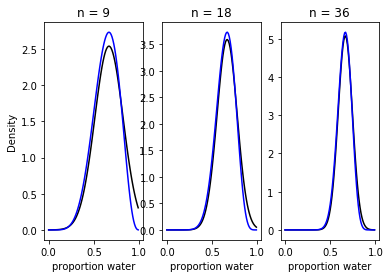

In [27]:
sdPost1 = np.sqrt(1/secondDerivPost(modePost1.x, 6, 9)[0])
modePost2 = minimize(negPost, x0=.5, args=(12, 18),
                     method='nelder-mead', options={'disp':False})
sdPost2 = np.sqrt(1/secondDerivPost(modePost2.x, 12, 18)[0])

modePost3 = minimize(negPost, x0=.5, args=(24, 36),
                     method='nelder-mead', options={'disp':False})
sdPost3 = np.sqrt(1/secondDerivPost(modePost2.x, 24, 36)[0])

plt.figure(1)
plt.subplot(131)
plt.plot(pRange, norm.pdf(pRange, modePost1.x, sdPost1), 'k-',
         pRange, beta.pdf(pRange, 7, 4), 'b-')
plt.title('n = 9')
plt.xlabel('proportion water')
plt.ylabel('Density')
plt.subplot(132)
plt.plot(pRange, norm.pdf(pRange, modePost2.x, sdPost2), 'k-',
         pRange, beta.pdf(pRange, 13, 7), 'b-')
plt.title('n = 18')
plt.xlabel('proportion water')
plt.subplot(133)
plt.plot(pRange, norm.pdf(pRange, modePost3.x, sdPost3), 'k-',
         pRange, beta.pdf(pRange, 25, 13), 'b-')
plt.title('n = 36')
plt.xlabel('proportion water')

#### Section 2.4.5: MCMC

Text(0, 0.5, 'density')

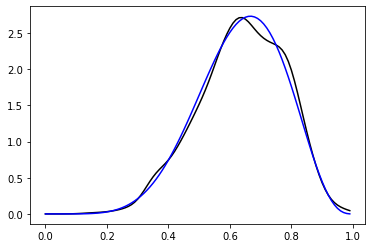

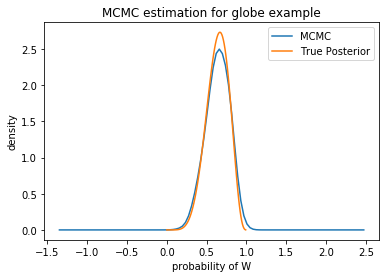

In [5]:
n_samples = 1000
p = np.full((1,n_samples), np.nan)
p[0, 0] = 0.5
W = 6
L = 3
i = 1
for i in np.arange(1, n_samples):
    p_new = np.random.normal(loc=p[0, i-1], scale=.1, size=1)
    p_new = abs(p_new) if p_new < 0 else p_new
    p_new = 2 - p_new if p_new > 1 else p_new
    q0 = binom.pmf(k = W, n = W + L, p = p[0, i-1])
    q1 = binom.pmf(k=W, n=W + L, p=p_new)
    p[0, i] = p_new if np.random.uniform(0, 1, 1) < q1/q0 else p[0, i-1]

plt.figure()
density = gaussian_kde(p)
plt.plot(pRange, density(pRange), 'k-',
         pRange, beta.pdf(pRange, 7, 4), 'b-')
type(p)
p.shape
p.reshape((n_samples, 1)).shape
p.reshape((n_samples)).shape
p = p.reshape((n_samples))
plt.figure()
sns.kdeplot(p, bw=0.5, label = 'MCMC')
sns.lineplot(pRange, beta.pdf(pRange, 7, 4), label = 'True Posterior')
plt.title('MCMC estimation for globe example')
plt.xlabel('probability of W')
plt.ylabel('density')